In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

Model definition

In [6]:
class CNN(nn.Module):
    def __init__(self,in_channels=3,num_filters1=16,num_filters2=20,padding=1,stride=1):
        super(CNN,self).__init__()

        self.conv1 =nn.Conv2d(in_channels=in_channels,out_channels=num_filters1,kernel_size=3,stride=stride,padding=padding)
        self.normalization1 = nn.BatchNorm2d(num_filters1)

        self.conv2 =nn.Conv2d(in_channels=num_filters1,out_channels=num_filters2,kernel_size=5,stride=stride,padding=padding)
        self.normalization2 = nn.BatchNorm2d(num_filters2)


        self.maxp = nn.MaxPool2d(kernel_size=3,stride=2)
        self.dropout = nn.Dropout(0.4)

        self.leaky_relu = nn.LeakyReLU(negative_slope=0.01)

    def forward(self, x):
        x = self.leaky_relu(self.normalization1(self.conv1(x)))  # (16, 128, 128)
        x = self.dropout(x)  # (16, 63, 63)
        x = self.maxp(x)  # (16, 63, 63)

        x = self.leaky_relu(self.normalization2(self.conv2(x)))  # (20, 61, 61)
        x = self.dropout(x)  # (20, 61, 61)
        x = self.maxp(x)  # (20, 30, 30)
        return x
    

class MLP(nn.Module):
    def __init__(self,inpt_size,num_classes=10):
        super(MLP,self).__init__()
    
        self.fc1 = nn.Linear(inpt_size, 512)
        self.normalization1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 256)
        self.normalization2 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256, 128)
        self.normalization3 = nn.BatchNorm1d(128)
        self.fc4 = nn.Linear(128, num_classes)

        self.dropout = nn.Dropout(0.5)
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.01)

    def forward(self, x):
        x = self.leaky_relu(self.normalization1(self.fc1(x)))
        x = self.dropout(x)

        x = self.leaky_relu(self.normalization2(self.fc2(x)))
        x = self.dropout(x)

        x = self.leaky_relu(self.normalization3(self.fc3(x)))
        x = self.dropout(x)

        x = self.fc4(x)
        return x



In [4]:
class FaceClassifier(nn.Module):
    def __init__(self,input_channels=3,mlp_inpt_size=20*30*30,num_classes=10):
        super(FaceClassifier,self).__init__()

        self.cnn = CNN(input_channels)

        self.mlp = MLP(mlp_inpt_size,num_classes=num_classes)

    def forward(self, x):
        x = self.cnn(x)
        x = x.view(x.size(0), -1)
        x = self.mlp(x)

        return x

In [5]:
# Definir una función para aplicar la inicialización de He
def init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):  # Conv2d o Linear son comunes en CNN y MLP
        torch.nn.init.kaiming_normal_(m.weight,nonlinearity='relu')  # Kaiming normal para ReLU
        if m.bias is not None:
            torch.nn.init.zeros_(m.bias)  # También inicializamos el bias a 0

In [9]:
from torchvision import datasets
from torch.utils.data import DataLoader,random_split
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np

# Definir las transformaciones para aumentar los datos
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Flip horizontal aleatorio
    transforms.RandomRotation(10),  # Rotación aleatoria hasta 10 grados
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Variación en el brillo y contraste
    transforms.RandomResizedCrop(128, scale=(0.8, 1.0)),  # Recorte y redimensionado aleatorio
    transforms.ToTensor(),  # Convertir a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalización
])


#Cargar datos
data_dir = "D:\\Faces"
dataset = datasets.ImageFolder(root=data_dir, transform=transform)

# Definir el tamaño del conjunto de entrenamiento y validación
train_size = int(0.8 * len(dataset))  # 80% para entrenamiento
val_size = len(dataset) - train_size  # 20% para validación


train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Crear DataLoaders para entrenamiento y validación
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True,num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False,num_workers=4)

print(f'Tamaño del conjunto de entrenamiento: {len(train_loader.dataset)}')
print(f'Tamaño del conjunto de validación: {len(val_loader.dataset)}')

Tamaño del conjunto de entrenamiento: 1113
Tamaño del conjunto de validación: 279


In [10]:
for i,j in enumerate(train_loader): 
    print(i,j[0].shape)
    if i == 10:
        break

0 torch.Size([16, 3, 128, 128])
1 torch.Size([16, 3, 128, 128])
2 torch.Size([16, 3, 128, 128])
3 torch.Size([16, 3, 128, 128])
4 torch.Size([16, 3, 128, 128])
5 torch.Size([16, 3, 128, 128])
6 torch.Size([16, 3, 128, 128])
7 torch.Size([16, 3, 128, 128])
8 torch.Size([16, 3, 128, 128])
9 torch.Size([16, 3, 128, 128])
10 torch.Size([16, 3, 128, 128])


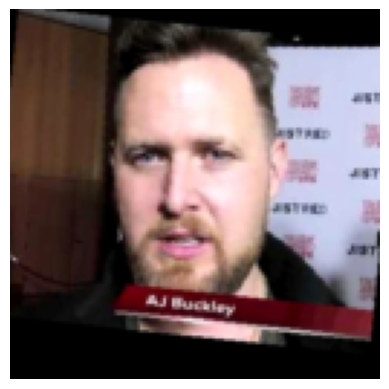

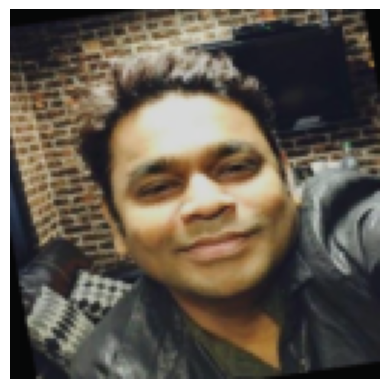

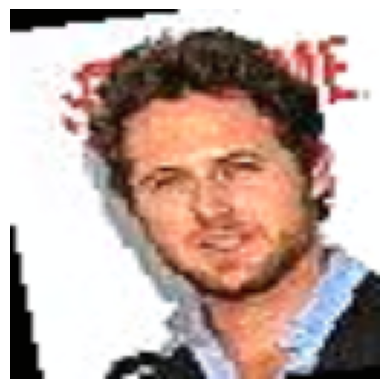

In [11]:
# Obtener un lote de imágenes
data_iter = iter(train_loader)
images, labels = next(data_iter)
# Función para desnormalizar imágenes
def imshow(img):
    img = img.numpy().transpose((1, 2, 0))  # Convertir de tensor a numpy y reordenar dimensiones
    mean = np.array([0.485, 0.456, 0.406])  # Valores de normalización (mean)
    std = np.array([0.229, 0.224, 0.225])   # Valores de normalización (std)
    img = std * img + mean  # Desnormalizar la imagen
    img = np.clip(img, 0, 1)  # Asegurarse de que los valores estén en el rango [0, 1]
    plt.imshow(img)
    plt.axis('off')  # Ocultar ejes
    plt.show()

# Visualizar imágenes aleatorias del lote transformado
for i in range(3):  # Visualizar las primeras 4 imágenes
    imshow(images[i])

In [12]:
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

# Entrenamiento del modelo
def train_and_validate(model, train_loader, val_loader, num_epochs=100,eta= 5e-5,n=1):
    # Inicializar el writer de TensorBoard
    writer = SummaryWriter(f'experimentos\\experimento_{n}')
    # Listas para almacenar las pérdidas de entrenamiento y validación
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    # Definir el optimizador y la función de perdida
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(),lr=eta)

    for epoch in range(num_epochs):
        # Modo de entrenamiento
        model.train()
        running_train_loss = 0.0
        correct_train = 0
        total_train = 0

        for images, labels in train_loader:
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward pass y optimización
            loss.backward()
            optimizer.step()
            
            running_train_loss += loss.item()

        
            # Calcular el accuracy en el conjunto de entrenamiento
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        # Calcular la pérdida promedio del conjunto de entrenamiento
        avg_train_loss = running_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Calcular la precisión en el conjunto de entrenamiento
        train_accuracy = 100 * correct_train / total_train
        train_accuracies.append(train_accuracy)

        # Modo de validación
        model.eval()
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():  # No se requiere cálculo de gradientes en validación
            for images, labels in val_loader:
                outputs = model(images)
                # Calcular la pérdida de validación
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()  # Acumular la pérdida por lote

                # Obtener la clase con mayor probabilidad (argmax)
                _, predicted = torch.max(outputs, 1)
                
                total_val += labels.size(0)  # Total de etiquetas
                correct_val += (predicted == labels).sum().item()  # Contar las predicciones correctas

        # Calcular la pérdida promedio del conjunto de validación
        avg_val_loss = running_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        # Calcular la precisión en el conjunto de validación
        val_accuracy = 100 * correct_val / total_val
        val_accuracies.append(val_accuracy)

        # Registrar las pérdidas y precisiones en TensorBoard
        writer.add_scalars('Losses', {'Training': avg_train_loss, 'Validation': avg_val_loss}, epoch)
        writer.add_scalars('Accuracies', {'Training': train_accuracy, 'Validation': val_accuracy}, epoch)


        if epoch%100:
            # Guardar el modelo entrenado
            torch.save(model.state_dict(), f'modelo_rostros{epoch}.pth')
            
        if epoch%10:
            print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f},Training accuracy: {train_accuracy:.4f} ,Validation Loss: {avg_val_loss:.4f},Validation Accuracy: {val_accuracy:.2f}%')

            
        writer.close()
    return train_losses, val_losses, train_accuracies, val_accuracies


In [14]:
# Crear el modelo
model = FaceClassifier(num_classes=len(dataset.classes))

# Cargar los pesos guardados
#checkpoint = torch.load('modelo_rostros48.pth')
#model.load_state_dict(checkpoint)

#Inicializamos los pesos con Xavier
#model.apply(init_weights)

# Entrenar y validar el modelo
train_losses, val_losses,train_accuracies, val_accuracies = train_and_validate(model, train_loader, val_loader, num_epochs=10000)

Epoch [2/10000], Training Loss: 1.4189,Training accuracy: 31.6262 ,Validation Loss: 1.3933,Validation Accuracy: 34.41%
Epoch [3/10000], Training Loss: 1.3737,Training accuracy: 36.7475 ,Validation Loss: 1.3207,Validation Accuracy: 41.94%
Epoch [4/10000], Training Loss: 1.4002,Training accuracy: 33.8724 ,Validation Loss: 1.3830,Validation Accuracy: 36.20%
Epoch [5/10000], Training Loss: 1.3633,Training accuracy: 37.6460 ,Validation Loss: 1.3792,Validation Accuracy: 36.20%
Epoch [6/10000], Training Loss: 1.3474,Training accuracy: 38.9937 ,Validation Loss: 1.3347,Validation Accuracy: 40.50%
Epoch [7/10000], Training Loss: 1.3525,Training accuracy: 38.7242 ,Validation Loss: 1.3389,Validation Accuracy: 40.14%
Epoch [8/10000], Training Loss: 1.3307,Training accuracy: 40.7907 ,Validation Loss: 1.2965,Validation Accuracy: 44.80%
Epoch [9/10000], Training Loss: 1.3268,Training accuracy: 40.9704 ,Validation Loss: 1.2887,Validation Accuracy: 45.16%
Epoch [10/10000], Training Loss: 1.3038,Training

RuntimeError: Caught RuntimeError in DataLoader worker process 1.
Original Traceback (most recent call last):
  File "c:\Users\derec\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\_utils\worker.py", line 309, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
           ^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\derec\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\_utils\fetch.py", line 55, in fetch
    return self.collate_fn(data)
           ^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\derec\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\_utils\collate.py", line 317, in default_collate
    return collate(batch, collate_fn_map=default_collate_fn_map)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\derec\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\_utils\collate.py", line 174, in collate
    return [collate(samples, collate_fn_map=collate_fn_map) for samples in transposed]  # Backwards compatibility.
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\derec\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\_utils\collate.py", line 142, in collate
    return collate_fn_map[elem_type](batch, collate_fn_map=collate_fn_map)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\derec\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\_utils\collate.py", line 212, in collate_tensor_fn
    storage = elem._typed_storage()._new_shared(numel, device=elem.device)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\derec\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\storage.py", line 968, in _new_shared
    untyped_storage = torch.UntypedStorage._new_shared(size * self._element_size(), device=device)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\derec\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\storage.py", line 300, in _new_shared
    return cls._new_using_filename_cpu(size)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: Couldn't open shared file mapping: <torch_20524_1768637347_34>, error code: <1455>
